In [1]:
import cv2
import numpy as np
import json
import CalibrationHelpers as calib
from ARImagePoseTracker import find_3d_points
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [41]:
num_image = 7 #6

DIM=(960, 540)

# Fisheye K and D
K, D, roi, new_intrinsics = calib.LoadCalibrationData('calib')
K_inv_fish = np.linalg.inv(K)

# Zed calibration K and D
f = open('calib/zed_left_calib.json')
zed_calib = json.load(f)
K_zed_l, D_zed_l = zed_calib['K'], zed_calib['D']
K_inv_zed = np.linalg.inv(K_zed_l)
f.close()

In [42]:
frame = cv2.imread("calib_fish/"+"calib_image_fish_" + str(num_image) + ".png")
zedframe = cv2.imread("calib_zed/"+"calib_image_zed_" + str(num_image) + ".png")

In [43]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
zedgray = cv2.cvtColor(zedframe, cv2.COLOR_BGR2GRAY)

In [44]:
# This undistortion works the best
nk = K.copy()
nk[0,0]=K[0,0]/2
nk[1,1]=K[1,1]/2
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), nk , DIM, cv2.CV_32FC1)
undistorted_img = cv2.remap(gray, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# # Alternative undistortion - not as good
# final_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, DIM, np.eye(3), balance=1.0)
# map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), final_K, DIM, cv2.CV_32FC1)
# undistorted_img = cv2.remap(gray, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Alternative undistortion - Really bad
# undistorted_img = cv2.fisheye.undistortImage(gray, K, D)

In [45]:
fisheyereference = cv2.resize(undistorted_img,DIM)
zedreference = cv2.resize(zedgray,(960, 540))

ret_fisheye, corners_undistfisheye = cv2.findChessboardCorners(undistorted_img, (6,9))
ret_distfisheye, corners_distfisheye = cv2.findChessboardCorners(gray, (6,9))

zedreference = cv2.undistort(zedreference, np.array(K_zed_l), np.array(D_zed_l), None, None)
ret_zed, corners_zed = cv2.findChessboardCorners(zedreference, (6,9))

In [46]:
# prints the image number, if the camera calibration print out is seen in the image
print(num_image, ret_fisheye, ret_distfisheye, ret_zed)

7 True True True


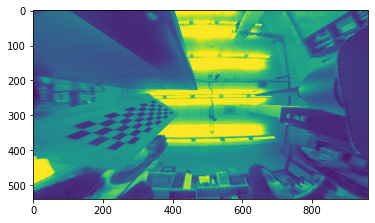

In [47]:
plt.imshow(undistorted_img)

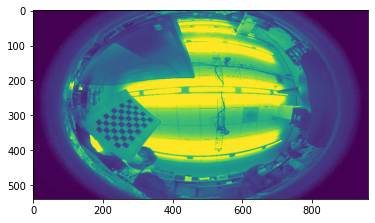

In [48]:
plt.imshow(gray)

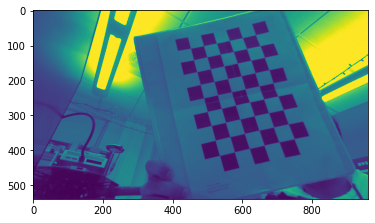

In [49]:
plt.imshow(zedreference)

In [50]:
# refines the corner locations
# https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

corners_fish_refin_undist = cv2.cornerSubPix(undistorted_img,corners_undistfisheye,(11,11),(-1,-1),criteria)
corners_fish_refin_dist = cv2.cornerSubPix(gray,corners_distfisheye,(11,11),(-1,-1),criteria)

corners_zed_refin = cv2.cornerSubPix(zedreference,corners_zed,(11,11),(-1,-1),criteria)

In [51]:
# Undistorting the refinded distorted points
undistPoints = cv2.fisheye.undistortPoints(corners_fish_refin_dist, K, D, np.eye(3), P=nk)

# Calculated the mean difference in both directions. 
# the mean of the difference for the undistrotion is calculated here 
np.mean(corners_fish_refin_undist - undistPoints, axis=0)

array([[ 1.4884084 , -0.45107496]], dtype=float32)

In [52]:
# apparently I need to normalize the point before undistorting it
# https://answers.opencv.org/question/172922/correct-use-of-fisheyedistortpoints/
homog_dist = np.append(corners_fish_refin_undist[:,0,:], np.ones(len(corners_fish_refin_undist))[:,np.newaxis], axis=1)
norm_corners_fish_refin_undist = K_inv_fish @ homog_dist.T

# help! The error here is much higher
# Distorting the refinded undistorted points
distPoints = cv2.fisheye.distortPoints(norm_corners_fish_refin_undist.T[:,np.newaxis,:2], K, D) 
# this one has a higher error
# distPoints = cv2.fisheye.distortPoints(corners_fish_refin_undist, K, D) 

# Calculated the mean difference in both directions. 
# the mean of the difference for the distortion is calculated here 
np.mean(corners_fish_refin_dist - distPoints , axis=0)

array([[-74.84789405,  18.88340174]])

In [53]:
def in_front_of_both_cameras(first_points, second_points, rot, trans):
    # check if the point correspondences are in front of both images
    rot_inv = rot
    for first, second in zip(first_points, second_points):
        second = np.append(second,1)
        first_z = np.dot(rot[0, :] - second[0]*rot[2, :], trans) / np.dot(rot[0, :] - second[0]*rot[2, :], second)
        first_3d_point = np.array([first[0] * first_z, first[1] * first_z, first_z])
        second_3d_point = np.dot(rot.T, first_3d_point) - np.dot(rot.T, trans)

        if first_3d_point[2] < 0 or second_3d_point[2] < 0:
            return False

    return True

def find_3d_points(points1, points2, P1, P2):
    def construct_A(points, P):
        x, y = points
 
        A = np.array([[P[0,0] - P[2,0] * x, P[0, 1] - P[2,1] * x, P[0,2] - P[2,2] * x,  P[0,3] - P[2,3] * x],
                      [P[1,0] - P[2,0] * y, P[1, 1] - P[2,1] * y, P[1,2] - P[2,2] * y,  P[1,3] - P[2,3] * y]])

        return A 

    points3D = []
    rec_err = []
    for p1, p2 in zip(points1, points2):
    
        A1 = construct_A(p1, P1)
        A2 = construct_A(p2, P2)

        A = np.array([A1,A2]).reshape((4,4))
        u_A, s_A, vh_A = np.linalg.svd(A)
        pt3d = vh_A[-1,:]
        pt3d = pt3d / pt3d[3] # Normalize by last number in column (should be 1)
        
        point3d = pt3d
        points3D.append(point3d)
        
    return np.array(points3D)

In [63]:
# Getting the R and T
# Approach 1: Passing in points that were from 
# F, mask = cv2.findFundamentalMat(undistPoints[:,0,:], corners_zed_refin[:,0,:], cv2.FM_RANSAC, 0.1, 0.99)
# print( undistPoints[:,0,:].shape, corners_zed_refin[:,0,:].shape)
# undist_pnt_corr, zed_pnt_corr = cv2.correctMatches(F, undistPoints[:,0,:], corners_zed_refin[:,0,:])

# # both images are already undistorted
# # i dont need to do the above part
# E = np.dot(np.dot(np.array(K_zed_l).T, F), K)
# so i will do this
E, _ = cv2.findEssentialMat(undistPoints[:,0,:], corners_zed_refin[:,0,:], np.eye(3), cv2.FM_RANSAC)
# E = F

r1, r2, t = cv2.decomposeEssentialMat(E)
posR = [r1, r1, r2, r2]
posT = [t, -t, t, -t]

# manual way to get the essential matrix
# U, S, Vt = np.linalg.svd(E)
# W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)

# corners_fisheye = undistPoints.reshape((54,2))
# corners_zed = corners2_zed.reshape((54,2))

# # Determine the correct choice of second camera matrix
# # only in one of the four configurations will all the points be in front of both cameras
# # First choice: R = U * Wt * Vt, T = +u_3 (See Hartley Zisserman 9.19)
# R1 = U.dot(W).dot(Vt)
# T = U[:, 2]

# posR = [U.dot(W).dot(Vt), U.dot(W).dot(Vt), U.dot(W.T).dot(Vt), U.dot(W.T).dot(Vt)]
# posT = [U[:, 2], - U[:, 2], U[:, 2], - U[:, 2]]

# this should give me the R and T that gives a positive Z value. If there are multiple I 
# will need to eval the one with the most posiive Z values
mask = [in_front_of_both_cameras(undistPoints[:,0,:], corners_zed_refin[:,0,:], r, t) for r,t in zip(posR, posT)]
print(mask)
for idx, in_front in enumerate(mask):
    if in_front:
        r, t = posR[idx], posT[idx]
        
        P1 = np.zeros((3,4))
        P1[:3, :3] = np.eye(3)
#         P1 = K @ P1
        
        temp = np.zeros((3,4))
        temp[:3, :3] = r
        temp[:, 3] = t.T
        P2 = np.array(K_zed_l) @ temp
        
        # my 3d points are not looking good
        points = find_3d_points(undistPoints[:,0,:], corners_zed_refin[:,0,:], P1, P2)
        
        zedPointsnew, _ = cv2.projectPoints(points[np.newaxis,:,:3], r, t, np.array(K_zed_l, dtype = np.float64), np.array(D_zed_l, dtype = np.float64))
        print("Reprojection Error Zed", np.linalg.norm(zedPointsnew - corners_zed_refin) / (len(zedPointsnew)))
        
        fisheyePointsnew, _ = cv2.fisheye.projectPoints(np.array(points[np.newaxis,:,:3], dtype = np.float64), 
                                                        np.zeros(3), 
                                                        np.zeros(3), 
                                                        np.array(K, dtype = np.float64), 
                                                        np.array(D, dtype = np.float64))
        print("Reprojection Error Fisheye", np.linalg.norm(fisheyePointsnew - undistPoints) / len(zedPointsnew))

[False, True, False, False]
4.626911897811127
576.9688842280885
615.5157813085547
Key pressed: s
Key pressed: s
Key pressed: s
Key pressed: s
Key pressed: s
Key pressed: s
Key pressed: s
Key pressed: s


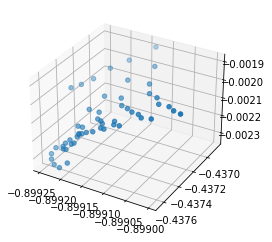

Key pressed: s


In [62]:
# visualizing the 3D points generated for the camera calibration matrix
np.random.seed(42)

xs = points[:,0]

ys = points[:,1]

zs = points[:,2]

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs,ys,zs)

plt.show()